In [ ]:
# CELL 1 (do not change)
"""import statements and boiler plate code"""
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
import tensorflow as tf
from keras import layers
from PIL import Image
from keras.callbacks import ModelCheckpoint

#For evaluating the model 
from sklearn.metrics import accuracy_score

#In case a validation set is required
from sklearn.model_selection import train_test_split


In [ ]:
# CELL 2 preprocessing
'''
to the pipeline:
    - add a random flip
    - random hue, max alpha = 0.3
    - random brightness, max alpha = 0.3
    - random_contrast, min = 0.9, max = 1.1
'''
##Setting an environmental variable so that CUDA doesn't run out of memory
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:100'

"""script to load data set and print info"""
with open('pokemon.pkl', 'rb') as f:
  df = pickle.load(f)                 # dataset dataframe
target = df.pop('Type1')

target = list(target)

#Counting how many images there are in the dataframe
number_images = len(df.axes[0])
#Initializing an empty numpy array for the images
img_array = np.empty(shape = (number_images, 120, 120, 3))
#Initializing a count variable
i = 0

for element in df['ImagePath']:
  element = element.replace("pokemon-contest/images/", '')

  #Convering the image into an RGB image first through PIL Image
  image = Image.open(element)
  image = image.convert('RGB')
  image = np.array(image)
  image = image.reshape((1, 120, 120, 3))

  # print("Shape of the loaded image: " +str(image.shape))

  #Attributing values in the empty array into the values from image
  img_array[i] = image
  i += 1

print(img_array.shape)

# #Creating a validation set and preprocessing the images
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.3)


# shape of validation data
#val_x.shape, val_y.shape



(647, 120, 120, 3)


In [ ]:
#Implementing One Hot Encoding
categories = np.array(list(set(target)))
n_categories = len(categories)
ohe_labels = np.zeros((len(target), n_categories))
for ii in range(len(target)):
  jj = np.where(categories == target[ii])
  ohe_labels[ii][jj] = 1


#Set Resizing, Rescaling and Data Augmentation
resize_and_rescale = Sequential([layers.Resizing(img_array.shape[1], img_array.shape[2])])
data_augmentation = Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                layers.RandomRotation(0.3), 
                                layers.RandomContrast(0.9, 1.1),
                                tf.keras.layers.RandomBrightness([-1, 0.3])
                                ])


In [ ]:
#Constructing the actual model
model = Sequential()
#Applying the Data Transformations
model.add(resize_and_rescale)
model.add(data_augmentation)

#Convolution layer findings: activation function tanh > relu, softsign seems to be a good function as well; padding = 'same'; strides = 6 (first)
model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', input_shape = (img_array.shape[1], img_array.shape[2], 3), padding = 'same', strides = 6))

# #Implementing a MaxPool Layer to reduce the number of parameters
# model.add(MaxPool2D(2))
#Adding a second convolution layer
model.add(Conv2D(50, kernel_size = 3, activation = 'softsign', input_shape = (img_array.shape[1], img_array.shape[2], 3), padding = 'same', dilation_rate = 6))
# #Utilizing Batch Normalization
# model.add(BatchNormalization())
#Using dropout to block out some of the noise
model.add(Dropout(0.05))
#Adding a third convolution layer
model.add(Conv2D(50, kernel_size = 3, activation = 'softsign', padding = 'same', dilation_rate = 6))
#Using dropout to block out some of the noise
model.add(Dropout(0.05))
#Fourth Convolution layer
model.add(Conv2D(240, kernel_size = 3, activation = 'softsign', padding = 'same', dilation_rate = 6))
#Using dropout to block out some of the noise
model.add(Dropout(0.05))
#Another Convolution layer
model.add(Conv2D(480, kernel_size = 3, activation = 'softsign', padding = 'same', strides = 3))
#Using dropout to block out some of the noise
model.add(Dropout(0.05))

#Another Convolution layer
model.add(Conv2D(120, kernel_size = 3, activation = 'tanh', padding = 'same', dilation_rate = 6))
#Another Convolution layer
model.add(Conv2D(120, kernel_size = 3, activation = 'sigmoid', padding = 'same'))
#Using dropout to block out some of the noise
model.add(Dropout(0.05))

#Another Convolution layer
model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', padding = 'same', dilation_rate = 6))
#Another Convolution layer
model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', padding = 'same'))
#Using dropout to block out some of the noise
model.add(Dropout(0.05))


# #Experimentation
# #Another Convolution layer
# model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', padding = 'same', dilation_rate = 6))
# #Another Convolution layer
# model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', padding = 'same'))
# #Using dropout to block out some of the noise
# model.add(Dropout(0.05))
# #Another Convolution layer
# model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', padding = 'same'))
# #Another Convolution layer
# model.add(Conv2D(15, kernel_size = 3, activation = 'tanh', padding = 'same'))







# #Using dropout to block out some of the noise
# model.add(Dropout(0.20))


model.add(Flatten())
model.add(Dense(len(categories), activation = 'softmax'))
#Compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting our data into the model: epochs = 30
training = model.fit(img_array, ohe_labels, validation_split = 0.2, epochs = 38, batch_size = 100)

Epoch 1/38


6/6 [==============================] - 10s 875ms/step - loss: 2.7925 - accuracy: 0.1083 - val_loss: 2.7777 - val_accuracy: 0.1154
Epoch 2/38
6/6 [==============================] - 5s 812ms/step - loss: 2.7698 - accuracy: 0.1315 - val_loss: 2.7550 - val_accuracy: 0.1154
Epoch 3/38
6/6 [==============================] - 5s 813ms/step - loss: 2.7450 - accuracy: 0.1431 - val_loss: 2.7254 - val_accuracy: 0.1077
Epoch 4/38
6/6 [==============================] - 5s 796ms/step - loss: 2.7281 - accuracy: 0.1257 - val_loss: 2.7322 - val_accuracy: 0.1462
Epoch 5/38
6/6 [==============================] - 6s 1s/step - loss: 2.7061 - accuracy: 0.1586 - val_loss: 2.6684 - val_accuracy: 0.1692
Epoch 6/38
6/6 [==============================] - 5s 805ms/step - loss: 2.6535 - accuracy: 0.1760 - val_loss: 2.7037 - val_accuracy: 0.1385
Epoch 7/38
6/6 [==============================] - 5s 810ms/step - loss: 2.6368 - accuracy: 0.1799 - val_loss: 2.6260 - val_accuracy: 0.1308
Epoch 8/38
6/6 [=================

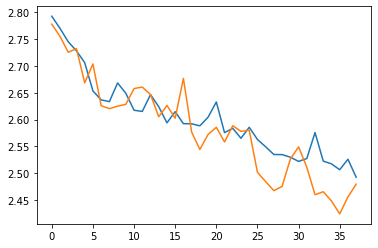

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_51 (Sequential)  (None, 120, 120, 3)       0         
                                                                 
 sequential_52 (Sequential)  (None, 120, 120, 3)       0         
                                                                 
 conv2d_153 (Conv2D)         (None, 20, 20, 15)        420       
                                                                 
 conv2d_154 (Conv2D)         (None, 20, 20, 50)        6800      
                                                                 
 dropout_102 (Dropout)       (None, 20, 20, 50)        0         
                                                                 
 conv2d_155 (Conv2D)         (None, 20, 20, 50)        22550     
                                                                 
 dropout_103 (Dropout)       (None, 20, 20, 50)      

In [ ]:
#Plotting the learning curve
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()

#Model Summary
model.summary()

In [ ]:
#This checkpoint will store the model parameters
checkpoint = ModelCheckpoint('weights.hdf5', monitor = 'val_loss', save_best_only = True)
#Store in a list to be used in training
callbacks_list = [checkpoint]
#Fit the model on a training set, using the checkpoint as a callback
model.fit(img_array, ohe_labels, validation_split = 0.2, epochs = 27, callbacks = callbacks_list)

Epoch 1/27
17/17 [==============================] - 3s 195ms/step - loss: 2.5656 - accuracy: 0.2089 - val_loss: 2.5791 - val_accuracy: 0.1538
Epoch 2/27
17/17 [==============================] - 3s 198ms/step - loss: 2.5924 - accuracy: 0.2031 - val_loss: 2.5877 - val_accuracy: 0.1615
Epoch 3/27
17/17 [==============================] - 4s 232ms/step - loss: 2.6129 - accuracy: 0.2012 - val_loss: 2.5790 - val_accuracy: 0.1692
Epoch 4/27
17/17 [==============================] - 4s 235ms/step - loss: 2.6165 - accuracy: 0.1973 - val_loss: 2.5414 - val_accuracy: 0.2000
Epoch 5/27
17/17 [==============================] - 4s 215ms/step - loss: 2.5979 - accuracy: 0.1838 - val_loss: 2.5327 - val_accuracy: 0.1692
Epoch 6/27
17/17 [==============================] - 4s 209ms/step - loss: 2.5743 - accuracy: 0.2263 - val_loss: 2.4865 - val_accuracy: 0.2231
Epoch 7/27
17/17 [==============================] - 4s 208ms/step - loss: 2.5417 - accuracy: 0.2321 - val_loss: 2.4690 - val_accuracy: 0.2308
Epoch 